# USA states classifier

This project is aimed at developing a classifier that can classify to which American state a city belongs given its Latitude and Logitude. I will be judging them based on their accuracy.

In [1]:
#package import
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

The data is cleaned to include 50 states and split into train and test data. <br>
Moreover, I will be using city ID as index in the model as city ascii has some duplicate values.

In [2]:
#Data cleaning
usa = pd.read_csv("uscities.csv",usecols=["city_ascii","state_name","lat","lng","id"])
usa.index= usa.id
usa = usa[~usa.state_name.isin (["District of Columbia", "Puerto Rico"])]
usa_cityid = usa.loc[:,"city_ascii"] #in usacityid we can check the which id belongs to which city
usa = usa.drop(["id","city_ascii"],axis=1)
usa_y = usa.pop("state_name")

#Test train split
X_train, X_test, y_train, y_test = train_test_split(usa,usa_y,random_state=4,stratify=usa_y)
usa.head(2)

,lat,lng
id,,
1840116412,46.9994,-122.3921
1840097718,47.2507,-121.0989


In [3]:
#pandas_profiling.ProfileReport(usa)
usa_y.nunique()

50

## <br> Dummy classifier

I will start by setting a baseline score using dummy classifier. <br>Then I will be looking to see how much of an improvement will I be able to get in each model. I will mostly be scoring model on the accuracy.

In [4]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="uniform", random_state=4)
dummy_clf.fit(X_train, y_train)
print('Uniformed dummy classifier train score: {:.4f}'.format(dummy_clf.score(X_train, y_train)))
print('Uniformed dummy classifier test score: {:.4f}'.format(dummy_clf.score(X_test, y_test)))

dummy_clf = DummyClassifier(strategy="stratified", random_state=4)
dummy_clf.fit(X_train, y_train)
print('Stratified dummy classifier train score: {:.4f}'.format(dummy_clf.score(X_train, y_train)))
print('Stratified dummy classifier test score: {:.4f}'.format(dummy_clf.score(X_test, y_test)))

Uniformed dummy classifier train score: 0.0190
Uniformed dummy classifier test score: 0.0188
Stratified dummy classifier train score: 0.0304
Stratified dummy classifier test score: 0.0293


This is a pretty low starting point of just around 3%. This low accuracy is a result of 50 unique labels. 

## <br>Guassian Naive Bayes

I will start trying to improve on the score with Gaussian Naive Bayes.

In [7]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
clf_Gauss=GaussianNB()
print('Naive Gaussian train score: {:.4f}'.format(cross_val_score(clf_Gauss,X_train,y_train,cv=5).mean()))
print('Naive Gaussian test score: {:.4f}'.format(cross_val_score(clf_Gauss,X_test,y_test,cv=5).mean()))

Naive Gaussian train score: 0.8975
Naive Gaussian test score: 0.8917


Gaussian Naive Bayes has achieved a test accuracy of 89.17%. This is already a massive improvement on the basile score of just 3%.

## <br>KNN Classifier

Secondly, I will be using K Nearest neighbour to classify the states. This model sounds like an intuitive solution for building the borders between the states. I am also tuning the hyperparameter n_neighbors to check which will produce the best result.

Best accuracy of KNN gridsearch: 0.9695
Best parameters of KNN gridsearch: {'n_neighbors': 7, 'weights': 'distance'}


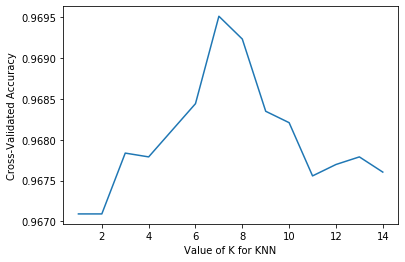

In [9]:
#importing classifier and Gridsearch to find hyperparameters
# GridSearchCV automatically refits the best model using all of the data

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

#defining classifier
knn_clf = KNeighborsClassifier(n_neighbors=3)
k_range = list(range(1, 15))

#defining options amd range for gridsearch
weight_options = ['distance']
param_grid = dict(n_neighbors=k_range, weights=weight_options)

knn_grid = GridSearchCV(knn_clf, param_grid, cv=5, scoring='accuracy', return_train_score=False)
knn_grid.fit(X_train, y_train)


#KNN results and best grid parameters
print('Best accuracy of KNN gridsearch: {:.4f}'.format(knn_grid.best_score_))
print('Best parameters of KNN gridsearch: {:}'.format(knn_grid.best_params_))

grid_mean_scores = knn_grid.cv_results_['mean_test_score']

plt.plot(k_range, grid_mean_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

In [10]:
from sklearn.metrics import classification_report
predicted = knn_grid.predict(X_test)
print(classification_report(y_test, predicted, target_names=usa_y.unique(), digits=4))

                precision    recall  f1-score   support

    Washington     0.9793    0.9726    0.9759       146
      Delaware     1.0000    1.0000    1.0000        88
     Wisconsin     0.9474    0.9643    0.9558       112
 West Virginia     0.9774    0.9701    0.9738       134
        Hawaii     0.9894    0.9947    0.9920       376
       Florida     0.9576    0.9912    0.9741       114
       Wyoming     0.9615    0.8929    0.9259        28
 New Hampshire     0.8421    0.8421    0.8421        19
    New Jersey     0.9828    1.0000    0.9913       228
    New Mexico     0.9806    0.9806    0.9806       155
         Texas     1.0000    1.0000    1.0000        37
     Louisiana     0.9623    0.9107    0.9358        56
        Alaska     0.9791    0.9619    0.9704       341
North Carolina     0.9822    0.9765    0.9794       170
  North Dakota     0.9686    0.9802    0.9744       252
      Nebraska     0.9532    0.9702    0.9617       168
     Tennessee     0.9389    0.9179    0.9283  

The KNN clasifier seems to perform around 97% regardless on the number of neighbors. The best score is achieved using 7 neighbors to classify the states. The test accuracy of 96.95% is a decent score

# Random forest

Lastly, I will try to use the random forest classifier. Usually random forest classifier tend to have one of the highest test scores, but takes considerably more time to train. I will try to tune 2 hyperparameters number of estimators and max leaf nodes using cross-validation. This will take around 10 minutes to run

In [11]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(n_estimators = 50,random_state=4)
estimator_list = [250,300,350]
max_leaf_nodes = [100,500,1000]
param_grid = dict(n_estimators=estimator_list, max_leaf_nodes=max_leaf_nodes)

rf_grid = GridSearchCV(clf_rf, param_grid, cv=5, scoring='accuracy', return_train_score=False)
rf_grid.fit(X_train, y_train)

#Random forest results and best grid parameters
print('Best accuracy of Random Forest gridsearch: {:.4f}'.format(rf_grid.best_score_))
print('Best parameters of Random Forest gridsearch: {:}'.format(rf_grid.best_params_))
print('Random forest test score: {:.4f}'.format(rf_grid.score(X_test,y_test)))

Best accuracy of Random Forest gridsearch: 0.9802
Best parameters of Random Forest gridsearch: {'max_leaf_nodes': 1000, 'n_estimators': 300}
Random forest test score: 0.9817


As expected Random Forest classifier managed to have the highest test score of 98.17. This was achieved using 1000 max leaf nodes and 300 estimators. I will graph different numbers of estimators to see how much of an impact it has compared to the number of max leaf nodes.

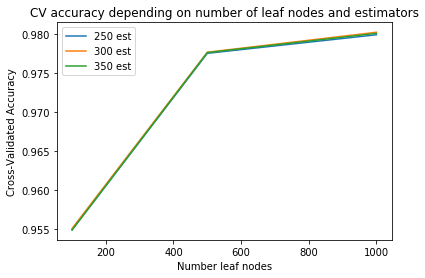

In [12]:
from pandas.io.json import json_normalize
rf_grid_scores=pd.DataFrame(rf_grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]
#It turns parameters into separate columns
rf_params = json_normalize(rf_grid_scores['params'])
#Merge them together
rf_params = pd.concat([rf_params,rf_grid_scores],axis=1)

#Create separate df for each value of n_estimators
rf_250_est = rf_params[rf_params.n_estimators == 250]
rf_300_est = rf_params[rf_params.n_estimators == 300]
rf_350_est = rf_params[rf_params.n_estimators == 350]

plt.title("CV accuracy depending on number of leaf nodes and estimators")
plt.xlabel('Number leaf nodes')
plt.ylabel('Cross-Validated Accuracy')
plt.plot(rf_250_est.max_leaf_nodes, rf_250_est.mean_test_score, label='250 est')
plt.plot(rf_300_est.max_leaf_nodes, rf_300_est.mean_test_score, label='300 est')
plt.plot(rf_350_est.max_leaf_nodes, rf_350_est.mean_test_score, label='350 est')
plt.legend()
plt.show()

So it seems that number of estimators has very low impact on the accuracy with lines basically overlapping each other.
On the other side the number of max leaf nodes seems to have a much bigger impact, with higher number contributing to higher

In [13]:
#trying with small number of estimators
clf_rf = RandomForestClassifier(n_estimators = 50,random_state=4)
estimator_list = [50,100,200,300]
max_leaf_nodes = [1000, 1500, 2000]
param_grid = dict(n_estimators=estimator_list, max_leaf_nodes=max_leaf_nodes)

rf_grid = GridSearchCV(clf_rf, param_grid, cv=10, scoring='accuracy', return_train_score=False)
rf_grid.fit(X_train, y_train)

print('Best accuracy of Random Forest gridsearch: {:.4f}'.format(rf_grid.best_score_))
print('Best parameters of Random Forest gridsearch: {:}'.format(rf_grid.best_params_))
print('Random forest test score: {:.4f}'.format(rf_grid.score(X_test,y_test)))

Best accuracy of Random Forest gridsearch: 0.9812
Best parameters of Random Forest gridsearch: {'max_leaf_nodes': 1500, 'n_estimators': 100}
Random forest test score: 0.9817


So it seems that I did not manage to get any real improvement on the test score by allowing for high number of max leaf nodes. I will finally graph the cross-validation accuracy for the hyperparameters.

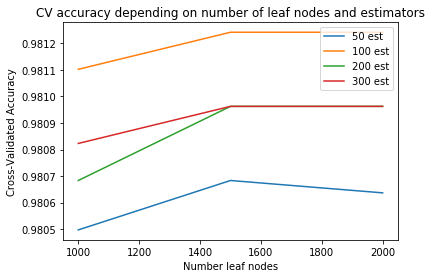

In [14]:
from pandas.io.json import json_normalize
rf_grid_scores=pd.DataFrame(rf_grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]
#It turns parameters into separate columns
rf_params = json_normalize(rf_grid_scores['params'])
#Merge them together
rf_params = pd.concat([rf_params,rf_grid_scores],axis=1)

#Create separate df for each value of n_estimators
rf_50_est = rf_params[rf_params.n_estimators == 50]
rf_100_est = rf_params[rf_params.n_estimators == 100]
rf_200_est = rf_params[rf_params.n_estimators == 200]
rf_300_est = rf_params[rf_params.n_estimators == 300]

plt.title("CV accuracy depending on number of leaf nodes and estimators")
plt.xlabel('Number leaf nodes')
plt.ylabel('Cross-Validated Accuracy')
plt.plot(rf_50_est.max_leaf_nodes, rf_50_est.mean_test_score, label='50 est')
plt.plot(rf_100_est.max_leaf_nodes, rf_100_est.mean_test_score, label='100 est')
plt.plot(rf_200_est.max_leaf_nodes, rf_200_est.mean_test_score, label='200 est')
plt.plot(rf_300_est.max_leaf_nodes, rf_300_est.mean_test_score, label='300 est')
plt.legend()
plt.show()

To conclude, all classifiers have managed to highly outperform the dummy classifier who's accuracy was only 3%. The best performer was the random forest classifier with test accuracy of 98.17%, followed by KNN with 96.98%.